In [2]:
import pandas as pd
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from clearml import Logger



/Users/vaceslav/lb/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузука файлов


In [3]:
data = pd.read_csv('/Users/vaceslav/Ml1/Origin/train.csv')
data_test = pd.read_csv('/Users/vaceslav/Ml1/Origin/test.csv')
sample_submission = pd.read_csv("/Users/vaceslav/Ml1/Origin/sample_submission.csv")
sample_submission_path = "/Users/vaceslav/Ml1/Origin/sample_submission.csv"

In [6]:
(data.head())

# data = data.drop(['Spends', 'Amount', 'NoSpends'] , axis = 1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Работа с данными

## Обновление параметров

### Заполнить пустые данные

In [4]:
def remove_Nan_data(data):
    
    # Разделяем данные на числовые и категориальные столбцы
    numeric_data = data.select_dtypes(["int", "float"]).columns
    categorical_data = data.select_dtypes(exclude=["int", "float"]).columns

    # Заполняем пропущенные значения в числовых столбцах медианой
    for col in numeric_data:
        data[col] = data[col].fillna(data[col].median())

    for col in categorical_data:
        most_frequent = data[col].mode()[0]  # Вычисляем самое частое значение
        data[col] = data[col].astype("object")  # Явно указываем, что это object
        data[col] = data[col].fillna(most_frequent)
        data[col] = data[col].infer_objects(copy=False)  # Явно преобразуем типы после fillna()

    return data

### Преобразовать данные (из bool в int) , добавление новых параетров

In [5]:
def Data_transform(data):
        cabin_data = data["Cabin"].str.split("/", expand=True)
        cabin_data.columns = ["Deck", "Num", "Side"]
        cabin_data["Num"] = cabin_data["Num"].fillna(-1).astype(int)
        cabin_data["Deck"] = cabin_data["Deck"].fillna("Unidentified")
        cabin_data["Side"] = cabin_data["Side"].fillna("Unidentified")
    
        data["CryoSleep"] = data["CryoSleep"].astype(bool).fillna(False).astype(int)
        data["VIP"] = data["CryoSleep"].astype(bool).fillna(False).astype(int)


        spends_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        data["Amount"] = data[spends_columns].sum(axis=1)


        numeric_columns = [
            'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "Amount", "Age", "CryoSleep", "VIP"
        ]
    
        numerics = data.copy()[numeric_columns]
        columns_for_dummies = ["HomePlanet", "Destination"]
        dummies = pd.get_dummies(cabin_data[["Deck", "Side"]].join(data.copy()[columns_for_dummies]))
        dummies = dummies.astype(int)

        result = pd.concat([numerics, dummies], axis=1)

        return result

In [6]:
data = remove_Nan_data(data)
data_test = remove_Nan_data(data_test)
X = Data_transform(data)
y = data['Transported'].astype('int')
X_test = Data_transform(data_test)

/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_82774/4104640482.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(most_frequent)
/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_82774/4104640482.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(most_frequent)
/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_82774/4104640482.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call r

In [8]:
X.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Amount,Age,CryoSleep,VIP,Deck_A,...,Deck_G,Deck_T,Side_P,Side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,109.0,9.0,25.0,549.0,44.0,736.0,24.0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,43.0,3576.0,0.0,6715.0,49.0,10383.0,58.0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
3,0.0,1283.0,371.0,3329.0,193.0,5176.0,33.0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
4,303.0,70.0,151.0,565.0,2.0,1091.0,16.0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


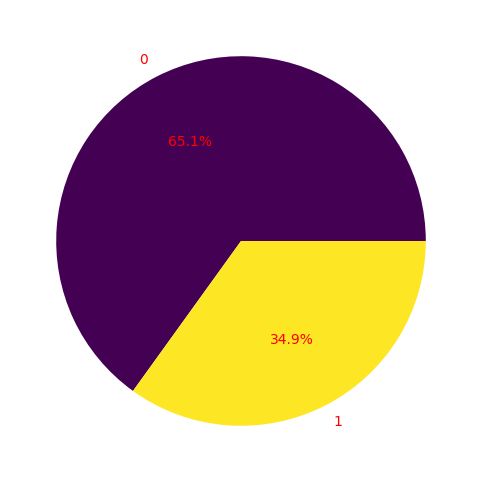

In [32]:
data["VIP"].value_counts().plot.pie(
    autopct="%1.1f%%",  
    cmap="viridis",
    figsize=(6, 6),
    textprops={'color': "red"}

)

plt.ylabel("")  
plt.show()

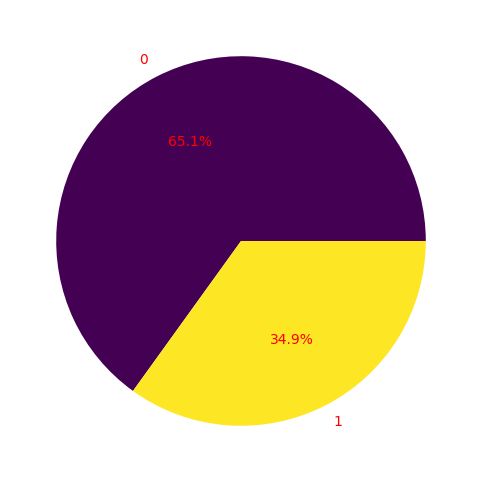

In [33]:
data["CryoSleep"].value_counts().plot.pie(
    autopct="%1.1f%%",  
    cmap="viridis",
    figsize=(6, 6) ,
    textprops={'color': "red"}
)

plt.ylabel("")  
plt.show()

## Логистическая Регрессия

### Подбор гиперпараметров

In [24]:
def objective_lr(trial, X, y):

    logger = Logger.current_logger()
    params = {
        'C': trial.suggest_loguniform("C", 1e-3, 10.0),
        'max_iter': trial.suggest_int("max_iter", 100, 10000),
        'solver': trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"]),
        'tol': trial.suggest_loguniform("tol", 1e-5, 1e-1),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'intercept_scaling': trial.suggest_loguniform("intercept_scaling", 0.1, 10.0),
        'class_weight': trial.suggest_categorical("class_weight", [None, "balanced"]),
        'warm_start': trial.suggest_categorical("warm_start", [True, False]),
    }
    logger.report_text(
            title="Logistic Regression Parameters",
            series="Params",
            iteration=trial.number,
            msg=str(params)  # Преобразуем словарь в строку
        )
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    model = LogisticRegression(
        C=params['C'], max_iter=params['max_iter'], solver=params['solver'], tol=params['tol'],
        fit_intercept=params['fit_intercept'], intercept_scaling=params['intercept_scaling'],
        class_weight=params['class_weight'], warm_start=params['warm_start'],
        random_state=17, n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

    valid_pred = model.predict_proba(X_valid_scaled)[:, 1]
    auc_score = roc_auc_score(y_valid, valid_pred)

    logger.report_scalar("AUC Score", "Logistic Regression", value=auc_score, iteration=trial.number)

    return auc_score    

### Вывод гиперпараметров

In [9]:
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(lambda trial: objective_lr(trial, X, y), n_trials=50)  # n_trials - количество попыток

print("Лучшие параметры Logistic Regression:", study_lr.best_params)

[I 2025-03-23 00:34:52,911] A new study created in memory with name: no-name-b4b0cb39-acd5-42e3-8d68-5137fd46b4b3
/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_82774/1600839573.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform("C", 1e-3, 10.0),
/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_82774/1600839573.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform("tol", 1e-5, 1e-1),
/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_82774/1600839573.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

AttributeError: 'NoneType' object has no attribute 'report_text'

### Обучение модели и Составление прогноза на основе полученных гиперпараметров

In [17]:
def get_auc_lr_valid(X, y, data_test, sample_submission_path, best_params, ratio=0.7, seed=17):

    train_len = int(ratio * X.shape[0])
    X_train, X_valid = X.iloc[:train_len, :], X.iloc[train_len:, :]
    y_train, y_valid = y.iloc[:train_len], y.iloc[train_len:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(data_test)

    logit = LogisticRegression(**best_params)
    
    logit.fit(X_train_scaled, y_train)

    valid_pred = logit.predict_proba(X_valid_scaled)[:, 1]
    auc_score = roc_auc_score(y_valid, valid_pred)

    precision, recall, thresholds = precision_recall_curve(y_valid, valid_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    test_pred = logit.predict_proba(X_test_scaled)[:, 1]
    test_pred_labels = test_pred >= best_threshold

    sample_submission = pd.read_csv(sample_submission_path)
    sample_submission["Transported"] = test_pred_labels.astype(bool)
    sample_submission.to_csv("sample_submission.csv", index=False)

    return auc_score, FileLink("sample_submission.csv")

In [15]:
auc, download_link = get_auc_lr_valid(X, y, X_test, sample_submission_path, study_lr.best_params)
print("AUC на валидации:", auc)
download_link


ValueError: No trials are completed yet.

## XGBoost

### Подбор гиперпарамаетров

In [18]:
def objective_xgb(trial, X, y, sample_submission_path, X_test):

    logger = Logger.current_logger()
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    valid_pred = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, valid_pred)

    logger.report_scalar("AUC Score", "XGBoost", value=auc_score, iteration=trial.number)

    return auc_score

### Обучение модели

In [19]:
def get_auc_xgb_valid(X, y, sample_submission_path, X_test, best_trial_xgb):

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.21, random_state=17, stratify=y
    )

    model = XGBClassifier(**study_xgb.best_trial.params) 
    model.fit(X_train, y_train)

    valid_pred = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, valid_pred)

    test_pred = model.predict_proba(X_test)[:, 1]
    test_pred_labels = test_pred >= 0.5  

    sample_submission = pd.read_csv(sample_submission_path)
    sample_submission["Transported"] = test_pred_labels.astype(bool)
    sample_submission.to_csv("sample_submission.csv", index=False)

    return auc_score, FileLink("sample_submission.csv")

### Составление прогноза на основе полученных гиперпараметров

In [15]:
study_xgb = optuna.create_study(direction='maximize')

study_xgb.optimize(lambda trial: objective_xgb(trial, X, y, sample_submission_path, X_test), n_trials=5)

best_trial_xgb = study_xgb.best_trial.params

print('Best trial for XGBoost:', best_trial_xgb)
auc, download_link = get_auc_xgb_valid(X, y, sample_submission_path, X_test, best_trial_xgb)


print("AUC-ROC на валидации:", auc)

download_link

[I 2025-03-22 23:40:54,813] A new study created in memory with name: no-name-615b6905-6714-4a13-8a0c-3d85dc532799
[W 2025-03-22 23:40:54,816] Trial 0 failed with parameters: {} because of the following error: NameError("name 'X' is not defined").
Traceback (most recent call last):
  File "/Users/vaceslav/lb/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/6b/70vj31n570513vy15fhb26980000gn/T/ipykernel_81577/4075285266.py", line 3, in <lambda>
    study_xgb.optimize(lambda trial: objective_xgb(trial, X, y, sample_submission_path, X_test), n_trials=5)
                                                          ^
NameError: name 'X' is not defined
[W 2025-03-22 23:40:54,818] Trial 0 failed with value None.


NameError: name 'X' is not defined

## Random Forest

### Подбор гиперпарамаетров

In [22]:
def objective_rf(trial, X, y):

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.3, random_state=17, stratify=y
    )

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    valid_pred = model.predict_proba(X_valid)[:, 1]

    auc_score = roc_auc_score(y_valid, valid_pred)

    logger.report_text(
    title="Logistic Regression Parameters",
    series="Params",
    iteration=trial.number,
    msg=str(params)  # Преобразуем словарь в строку
    )

    return auc_score

### Обучение модели

In [18]:
def get_auc_rf_valid(X, y, sample_submission_path, X_test, best_trial_rf): 

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.21, random_state=17, stratify=y
    )

    model = RandomForestClassifier(**best_trial_rf.params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    valid_pred = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, valid_pred)

    test_pred = model.predict_proba(X_test)[:, 1]
    test_pred_labels = test_pred >= 0.5  # бинаризация

    sample_submission = pd.read_csv(sample_submission_path)
    sample_submission["Transported"] = test_pred_labels.astype(bool)
    sample_submission.to_csv("sample_submission_rf.csv", index=False)

    return auc_score, FileLink("sample_submission_rf.csv")

### Составление прогноза на основе полученных гиперпараметров

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_rf(trial, X, y), n_trials=60)


best_trial_rf = study.best_trial

print('Лучшие параметры rf:', best_trial_rf)

auc, download_link = get_auc_rf_valid(X, y, sample_submission_path, X_test, best_trial_rf)


print("AUC-ROC на валидации:", auc)

download_link


[I 2025-03-20 21:26:38,194] A new study created in memory with name: no-name-be1e3ed1-8aee-4248-8467-371b7ced494e
[I 2025-03-20 21:26:38,340] Trial 0 finished with value: 0.8812639862144811 and parameters: {'n_estimators': 135, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 0.29890145661221346, 'bootstrap': False}. Best is trial 0 with value: 0.8812639862144811.
[I 2025-03-20 21:26:38,926] Trial 1 finished with value: 0.8811978227819812 and parameters: {'n_estimators': 617, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.14407071088157394, 'bootstrap': True}. Best is trial 0 with value: 0.8812639862144811.
[I 2025-03-20 21:26:39,884] Trial 2 finished with value: 0.880984629499481 and parameters: {'n_estimators': 502, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.7132436363358255, 'bootstrap': False}. Best is trial 0 with value: 0.8812639862144811.
[I 2025-03-20 21:26:41,053] Trial 3

Лучшие параметры rf: FrozenTrial(number=51, state=1, values=[0.8961195881987962], datetime_start=datetime.datetime(2025, 3, 20, 21, 27, 9, 520254), datetime_complete=datetime.datetime(2025, 3, 20, 21, 27, 10, 68563), params={'n_estimators': 493, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.4125040398874704, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=51, value=None)
AUC-ROC на валидации: 0.8937685958345329


/Users/vaceslav/sample_submission_rf.csv

## Функция записи submission_file

In [1]:
logit = LogisticRegression(**study_lr.best_params)
logit.fit(X, y)

NameError: name 'LogisticRegression' is not defined

In [171]:
test_pred = logit.predict_proba(X_test)[:, 1]
test_pred_labels = test_pred >= 0.5

In [172]:
sample_submission = pd.DataFrame({
    "PassengerId": sample_submission["PassengerId"], 
    "Transported": test_pred_labels1 
})

In [173]:
sample_submission.to_csv("sample_submission.csv", index=False)


In [174]:
FileLink("sample_submission.csv")

/Users/vaceslav/sample_submission.csv

## Подключение Clearml

In [28]:
from clearml import Task
import joblib 
task = Task.init(project_name='Hits2025_Ml1', task_name='Hyperparameter Tuning with Optuna')

In [29]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(lambda trial: objective_xgb(trial, X, y, sample_submission_path, X_test), n_trials=50)

# study_lr = optuna.create_study(direction="maximize")
# study_lr.optimize(lambda trial: objective_lr(trial, X, y), n_trials=50)
# 
best_params_xgb = study_xgb.best_params
# best_params_lr = study_lr.best_params

task.connect({ "XGB Best Params": best_params_xgb})

best_model_xgb = XGBClassifier(**best_params_xgb)
best_model_xgb.fit(X, y)
joblib.dump(best_model_xgb, "best_model_xgb.pkl")
task.upload_artifact("Best XGBoost Model", "best_model_xgb.pkl")

# best_model_lr = LogisticRegression(**best_params_lr)
# best_model_lr.fit(X, y)
# joblib.dump(best_model_lr, "best_model_lr.pkl")
# task.upload_artifact("Best Logistic Regression Model", "best_model_lr.pkl")

task.close()   

[I 2025-03-23 00:55:00,062] A new study created in memory with name: no-name-6006adcd-e8c1-48e0-8973-4ea9751d40a0
[I 2025-03-23 00:55:01,450] Trial 0 finished with value: 0.8956723233950957 and parameters: {'booster': 'gbtree', 'lambda': 7.6932279201566995, 'alpha': 0.001338657506375617, 'learning_rate': 0.013012135390203312, 'n_estimators': 614, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.0014363646994433447, 'subsample': 0.5190694430200999, 'colsample_bytree': 0.968780104450482}. Best is trial 0 with value: 0.8956723233950957.
[I 2025-03-23 00:55:30,185] Trial 1 finished with value: 0.8802918248462803 and parameters: {'booster': 'dart', 'lambda': 0.0012816358529083314, 'alpha': 5.293657917286142, 'learning_rate': 0.0015204560534338623, 'n_estimators': 533, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.39875269509115496, 'subsample': 0.624313346415625, 'colsample_bytree': 0.5210931642724737}. Best is trial 0 with value: 0.8956723233950957.
/Users/vaceslav/lb/lib/python3.13/s

## Загрузка на cleaarML

In [31]:
X.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Amount,Age,CryoSleep,VIP,Deck_A,...,Deck_G,Deck_T,Side_P,Side_S,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,109.0,9.0,25.0,549.0,44.0,736.0,24.0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,43.0,3576.0,0.0,6715.0,49.0,10383.0,58.0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
3,0.0,1283.0,371.0,3329.0,193.0,5176.0,33.0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
4,303.0,70.0,151.0,565.0,2.0,1091.0,16.0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [ ]:
from clearml import Dataset

X.to_csv("Update_data.csv", index=False) 

dataset = Dataset.create(
    dataset_name="XGBalg",  
    dataset_project="Spaceship"  
)


dataset.add_files(path="Update_data.csv")

dataset.upload()

dataset.finalize()
print("Набор данных успешно загружен на сервер ClearML!")

